# *Лабораторная работа №3*

## Определение типа дорожного знака (Теоретическая часть)

Подключим все необходимые библиотеки.

In [ ]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим датасет в среду выполнения.

In [ ]:
%%capture
!wget https://www.dropbox.com/s/7xi7of75tbuouo2/Meta.zip

Распакуем все данные для дальнейшей работы.

In [ ]:
zip = ZipFile('Meta.zip')
zip.extractall()

Укажем основные пути к папкам и введем масштаб, к которому будем приводить все изображения датасета.

In [ ]:
data_dir = '/content/'
train_path = '/content/Train'

height = 30
width = 30
channels = 3

Создадим массивы для хранения изображений и их категорий. Дополнительно рассмотрим общее количество категорий в данном датасете.

In [ ]:
data = []
labels = []
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

Заполним массивы изображений и меток классов.

In [ ]:
for i in range(NUM_CATEGORIES):
    path = os.path.join(train_path,str(i))
    images = os.listdir(path)
    for a in images:
            image = Image.open(path + '/' + a)
            image = image.resize((height,width))
            image = np.array(image)
            data.append(image)
            labels.append(i)

data = np.array(data)
labels = np.array(labels)

In [ ]:
data

array([[[[120, 125, 129],
         [121, 123, 128],
         [123, 123, 128],
         ...,
         [140, 138, 144],
         [116, 117, 116],
         [116, 117, 118]],

        [[124, 127, 131],
         [124, 125, 130],
         [123, 123, 130],
         ...,
         [150, 149, 159],
         [122, 122, 123],
         [121, 115, 117]],

        [[131, 132, 145],
         [127, 131, 146],
         [122, 128, 145],
         ...,
         [179, 175, 182],
         [161, 155, 161],
         [157, 145, 152]],

        ...,

        [[ 94,  96,  97],
         [ 92,  95,  94],
         [ 94,  95,  97],
         ...,
         [122, 128, 137],
         [ 92,  98, 102],
         [ 95,  98,  98]],

        [[ 84,  88,  89],
         [ 88,  90,  91],
         [ 89,  90,  94],
         ...,
         [126, 132, 140],
         [ 93,  98, 104],
         [ 96,  97, 101]],

        [[ 88,  88,  89],
         [ 85,  88,  88],
         [ 87,  92,  95],
         ...,
         [124, 130, 137],
        

In [ ]:
labels

array([ 0,  0,  0, ..., 42, 42, 42])

Разобьем данные на тренировочную и тестовую выборки в рамках обучения нейронной сети. Также проведем нормализацию в процессе.

In [ ]:
print(data.shape,labels.shape)

X_train, X_test, Y_train, Y_test = train_test_split(data,labels,test_size=0.2,random_state=42, shuffle=True)

X_train = X_train/255
X_test = X_test/255

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [ ]:
Y_train=keras.utils.to_categorical(Y_train,NUM_CATEGORIES)
Y_test= keras.utils.to_categorical(Y_test,NUM_CATEGORIES)

print(Y_train.shape)
print(Y_test.shape)

(31367, 43)
(7842, 43)


Создадим модель, состоящую из последовательно идущих слоев:

*   Свертка (32 фильтра 3х3)
*   Свертка (32 фильтра 3х3)
*   Субдискретизация (фильтр max 2х2)
*   Свертка (64 фильтра 3х3)
*   Свертка (64 фильтра 3х3)
*   Субдискретизация (фильтр max 2х2)
*   Полносвязный слой (512 нейронов)
*   Полносвязный слой (*количество_категорий* нейронов)

Кроме того введем выключение части нейронов для предотвращения переобучения.


In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(height,width,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0

Скомпилируем созданную модель.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Зададим функцию аугментации, чтобы незначительно изменять изображения для искусственного расширения набора данных при обучении.

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

Задаим размер пакета обучения равным 32 и количсество эпох равным 15.

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(aug.flow(X_train,Y_train,batch_size=batch_size),
                    epochs=epochs, validation_data=(X_test, Y_test) )

Epoch 1/15
981/981 [==============================] - 110s 111ms/step - loss: 2.6487 - accuracy: 0.2583 - val_loss: 0.3674 - val_accuracy: 0.8792
Epoch 2/15
981/981 [==============================] - 111s 113ms/step - loss: 0.6714 - accuracy: 0.7850 - val_loss: 0.0841 - val_accuracy: 0.9782
Epoch 3/15
981/981 [==============================] - 111s 113ms/step - loss: 0.3432 - accuracy: 0.8915 - val_loss: 0.0441 - val_accuracy: 0.9880
Epoch 4/15
981/981 [==============================] - 114s 117ms/step - loss: 0.2264 - accuracy: 0.9301 - val_loss: 0.0192 - val_accuracy: 0.9941
Epoch 5/15
981/981 [==============================] - 111s 113ms/step - loss: 0.1883 - accuracy: 0.9399 - val_loss: 0.0186 - val_accuracy: 0.9966
Epoch 6/15
981/981 [==============================] - 110s 113ms/step - loss: 0.1508 - accuracy: 0.9545 - val_loss: 0.0169 - val_accuracy: 0.9946
Epoch 7/15
981/981 [==============================] - 111s 113ms/step - loss: 0.1297 - accuracy: 0.9611 - val_loss: 0.0119 -

Выведем графики изменения точности и величины функции ошибки в процессе обучения модели.

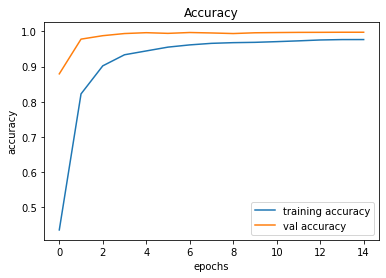

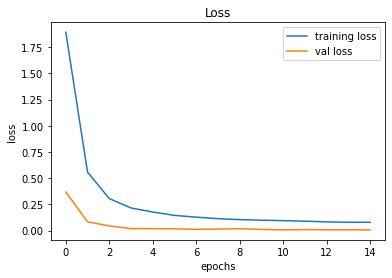

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Повторим все действия, которые мы делали для подготовки тренировочного набора данных, для тестовых данных.

In [ ]:
test = pd.read_csv(data_dir + 'Test.csv')

labels = test["ClassId"].values
images = test["Path"].values

data=[]

for a in images:
  image = Image.open(data_dir + '/' + a)
  image = image.resize((height,width))
  image = np.array(image)
  data.append(image)

In [ ]:
X_pred = np.array(data)
X_pred = X_pred/255

Получим предсказание величин для тестовой выборки.

In [ ]:
pred = model.predict_classes(X_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Выведем величину метрики точности для тестового набора данных.

In [ ]:
from sklearn.metrics import accuracy_score

print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.36896278701505


## Определение вида бабочки по изображению (Практическая часть)

###Задание базового уровня

Вашим заданием в данной лабораторной будет построение модели на основе сверточных нейронных сетей для определения вида бабочки по ее фотографии.

Методика оценки - accuracy_score

В наборе данных представлены фотографии 75 видов бабочек. Все изображения имеют разрешение 224х224. Имя каждого файла состоит из названия вида бабочки и порядкового номера изображения.

###Задание повышенного уровня

Выполнить задание базового уровня. Классификатор должен показывать точность по метрике accuracy_score на валидационных данных выше 80%.

Загрузим набор данных для обработки.

In [ ]:
%%capture
!wget https://www.dropbox.com/s/ivy51wqobna8wbt/train_fix.zip
!wget https://www.dropbox.com/s/lot1946ol8q8u85/test.zip

In [ ]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
import re
import shutil
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Activation, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
zip_train = ZipFile('train_fix.zip')
zip_train.extractall()
zip_test = ZipFile('test.zip')
zip_test.extractall()

In [ ]:
data_dir = '/content/'
train_path = '/content/train/train/'
test_path = '/content/test/'
train_img_path = '/content/train_img/'
test_img_path = '/content/test_img/'

In [ ]:
# Создаем папки для категорий
os.makedirs(train_img_path, exist_ok=True)
os.makedirs(test_img_path, exist_ok=True)

In [ ]:
def img_in_dir(source_dir, destination_dir):

  # Получаем список всех файлов в исходной директории
  files = os.listdir(source_dir)

  # Проходим по каждому файлу
  for file in files:
      # Получаем имя файла до символа '('
      folder_name = file.split(' (')[0].lower()
      # Путь к папке назначения
      dest_folder = os.path.join(destination_dir, folder_name)

      # Проверяем существует ли папка назначения
      if not os.path.exists(dest_folder):
          os.makedirs(dest_folder)  # Создаем папку если не существует

      # Перемещаем файл в папку назначения
      shutil.move(os.path.join(source_dir, file), os.path.join(dest_folder, file))

In [ ]:
img_in_dir(train_path, train_img_path)
img_in_dir(test_path, test_img_path)

In [ ]:
data = []
labels = []
NUM_CATEGORIES = len(os.listdir(train_img_path))
NUM_CATEGORIES

75

In [ ]:
# Каталог с данными для обучения
train_dir = train_img_path
# Каталог с данными для тестирования
test_dir = test_img_path
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Количество эпох
epochs = 30
# Размер мини-выборки
batch_size = 16
# Количество изображений для обучения
nb_train_samples = 9285
# Количество изображений для тестирования
nb_test_samples = 750

Генератор изображений создается на основе класса ImageDataGenerator. Генератор делит значения всех пикселов изображения на 255.

In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

Генератор данных для обучения на основе изображений из каталога

In [ ]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 9285 images belonging to 75 classes.


Генератор данных для тестирования на основе изображений из каталога

In [ ]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 750 images belonging to 75 classes.


###Создаем сверточную нейронную сеть
**Архитектура сети**

1. Слой свертки, размер ядра 3х3, количество карт признаков - 32 шт., функция активации ReLU.
2. Слой подвыборки, выбор максимального значения из квадрата 2х2
3. Слой свертки, размер ядра 3х3, количество карт признаков - 32 шт., функция активации ReLU.
4. Слой подвыборки, выбор максимального значения из квадрата 2х2
5. Слой свертки, размер ядра 3х3, количество карт признаков - 64 шт., функция активации ReLU.
6. Слой подвыборки, выбор максимального значения из квадрата 2х2
7. Слой преобразования из двумерного в одномерное представление
8. Полносвязный слой, 64 нейрона, функция активации ReLU.
9. Слой Dropout.
10. Выходной слой, 1 нейрон, функция активации sigmoid.

Слои с 1 по 6 используются для выделения важных признаков в изображении, а слои с 7 по 10 - для классификации.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(75))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

###Обучаем модель с использованием генераторов

train_generator - генератор данных для обучения

validation_data - генератор данных для проверки

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs)

Epoch 1/30


<ipython-input-16-408181fb206b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


580/580 [==============================] - 21s 26ms/step - loss: 4.0974 - accuracy: 0.0435
Epoch 2/30
580/580 [==============================] - 16s 28ms/step - loss: 3.2963 - accuracy: 0.1569
Epoch 3/30
580/580 [==============================] - 14s 24ms/step - loss: 2.7252 - accuracy: 0.2567
Epoch 4/30
580/580 [==============================] - 15s 26ms/step - loss: 2.3723 - accuracy: 0.3257
Epoch 5/30
580/580 [==============================] - 16s 27ms/step - loss: 2.0965 - accuracy: 0.3874
Epoch 6/30
580/580 [==============================] - 15s 25ms/step - loss: 1.8972 - accuracy: 0.4280
Epoch 7/30
580/580 [==============================] - 16s 27ms/step - loss: 1.7377 - accuracy: 0.4684
Epoch 8/30
580/580 [==============================] - 17s 28ms/step - loss: 1.6291 - accuracy: 0.4956
Epoch 9/30
580/580 [==============================] - 15s 26ms/step - loss: 1.4717 - accuracy: 0.5340
Epoch 10/30
580/580 [==============================] - 16s 27ms/step - loss: 1.3910 - accurac


###Оцениваем качество работы сети с помощью генератора

In [ ]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)

<ipython-input-17-95bfb2ba4b2e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)


In [ ]:
print("Аккуратность на тестовых данных: %.2f%%" % (scores[1]*100))

Аккуратность на тестовых данных: 68.89%


Зададим функцию аугментации, чтобы незначительно изменять изображения для искусственного расширения набора данных при обучении.

In [ ]:
aug_train_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")
aug_train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    )

Found 9285 images belonging to 75 classes.


In [ ]:
history = model.fit_generator(
    aug_train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs)

Epoch 1/15


<ipython-input-23-7dfd26972473>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


290/290 [==============================] - 15s 49ms/step - loss: 0.6111 - accuracy: 0.7915
Epoch 2/15
290/290 [==============================] - 14s 47ms/step - loss: 0.5727 - accuracy: 0.7993
Epoch 3/15
290/290 [==============================] - 13s 45ms/step - loss: 0.5557 - accuracy: 0.8037
Epoch 4/15
290/290 [==============================] - 14s 47ms/step - loss: 0.5486 - accuracy: 0.8097
Epoch 5/15
290/290 [==============================] - 14s 49ms/step - loss: 0.5485 - accuracy: 0.8071
Epoch 6/15
290/290 [==============================] - 14s 49ms/step - loss: 0.5228 - accuracy: 0.8172
Epoch 7/15
290/290 [==============================] - 13s 46ms/step - loss: 0.5150 - accuracy: 0.8211
Epoch 8/15
290/290 [==============================] - 14s 47ms/step - loss: 0.5099 - accuracy: 0.8180
Epoch 9/15
290/290 [==============================] - 14s 47ms/step - loss: 0.5217 - accuracy: 0.8168
Epoch 10/15
290/290 [==============================] - 13s 45ms/step - loss: 0.5149 - accurac

In [ ]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)

<ipython-input-24-95bfb2ba4b2e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)


In [ ]:
print("Accuracy на тестовых данных: %.2f%%" % (scores[1]*100))

Аккуратность на тестовых данных: 72.83%


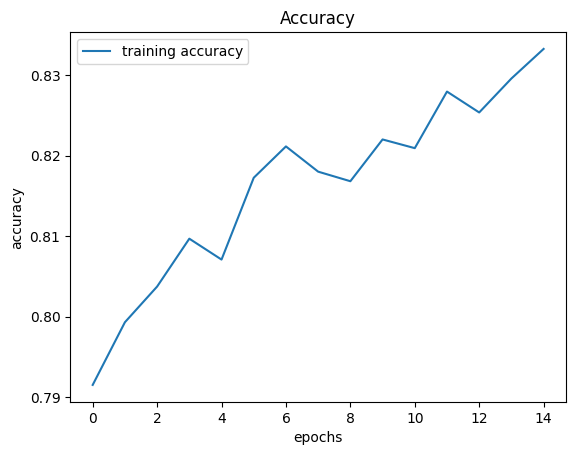

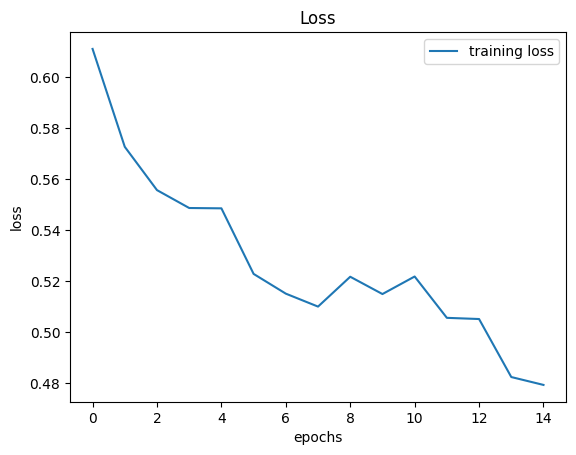

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()